In [1]:
from util import *
from expval_calc_q_optim import *
from generate_training_set import *

from qiskit.utils import QuantumInstance 
from qiskit import Aer
import qiskit.providers.aer.noise as noise

import matplotlib.pyplot as plt

In [2]:
# Create appropriate instances
# Error probabilities
prob_1 = 0.01  # 1-qubit gate
prob_2 = 0.1   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

qasm_backend = Aer.get_backend('qasm_simulator')
em_instance = QuantumInstance(backend = qasm_backend, noise_model= noise_model, shots = 10000)
sv_backend = Aer.get_backend('aer_simulator_statevector')
ef_instance = QuantumInstance(backend = sv_backend)

In [3]:
# LBEM
seed = 100

group_pauli_op, [ansatz,num_par_gates] = main('H2', 0.774, 2, 1, 'simple')
group_pauli_op = group_pauli_op['grouped_paulis']
print('Ansatz & qubit hamiltonian created')

trunc_T, trunc_P = truncate_training_set(num_par_gates, 0, 0, s = seed, exhaustive= True)
circuit_list = get_circuits_dict(ansatz, trunc_T, trunc_P, num_par_gates)
print('Training circuits generated')

com_ef, com_em = expval_calc(group_pauli_op, circuit_list, em_instance, ef_instance)
print('All expectation values calculated')

q = q_optimize(group_pauli_op, circuit_list, com_em, com_ef)
print('q optimized')

Ansatz & qubit hamiltonian created
Training circuits generated
All expectation values calculated
q optimized


In [4]:
# Test using some random angles
angles = (2*np.pi/20) * np.array(list(range(20)))
efs = []
ems = []
ns = []

for angle in angles:
    ef_expval, em_expval, n_expval = test(ansatz, [angle], group_pauli_op, q, ef_instance, em_instance)
    print('Angle: {} | Error free value: {} | Error mitigated value: {} | Noisy value: {}'.format(angle, ef_expval, em_expval, n_expval))
    
    efs.append(ef_expval)
    ems.append(em_expval)
    ns.append(n_expval)

Angle: 0.0 | Error free value: (-0.7381674497530166+0j) | Error mitigated value: (-0.7433104232295549+0j) | Noisy value: (-0.5968332945031277+0j)
Angle: 0.3141592653589793 | Error free value: (-0.7203725283225806+0j) | Error mitigated value: (-0.7214128379783782+0j) | Noisy value: (-0.5772836312642937+0j)
Angle: 0.6283185307179586 | Error free value: (-0.6687296549253914+0j) | Error mitigated value: (-0.6690921138148093+0j) | Noisy value: (-0.5389317020778736+0j)
Angle: 0.9424777960769379 | Error free value: (-0.5882939938266231+0j) | Error mitigated value: (-0.594873380340114+0j) | Noisy value: (-0.4849565959032985+0j)
Angle: 1.2566370614359172 | Error free value: (-0.48693914796282733+0j) | Error mitigated value: (-0.4845314678722534+0j) | Noisy value: (-0.39364049350436936+0j)
Angle: 1.5707963267948966 | Error free value: (-0.37458643582788836+0j) | Error mitigated value: (-0.37600737564912023+0j) | Noisy value: (-0.30693560429675476+0j)
Angle: 1.8849555921538759 | Error free value:

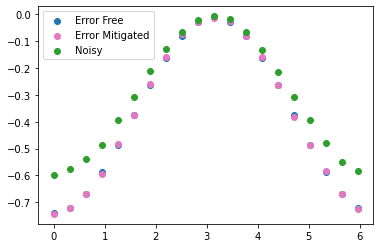

In [5]:
plt.scatter(angles, efs, c = 'tab:blue', label = 'Error Free')
plt.scatter(angles, ems, c = 'tab:pink', label = 'Error Mitigated')
plt.scatter(angles, ns, c = 'tab:green', label = 'Noisy')
plt.legend()

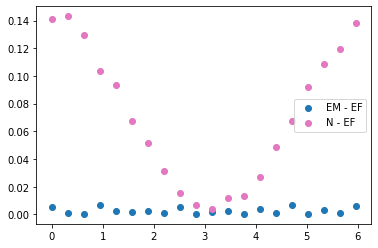

In [6]:
plt.scatter(angles, np.abs(np.array(ems) - np.array(efs)), c = 'tab:blue', label = 'EM - EF')
plt.scatter(angles, np.abs(np.array(ns) - np.array(efs)), c = 'tab:pink', label = 'N - EF')
plt.legend()